In [2]:
import torch
import pandas as pd
from transformers import PatchTSTConfig, PatchTSTForRegression

# Load the weather data from CSV
weather_data = pd.read_csv('../data/miami_weather.csv')
max_temp = weather_data['temperature_2m_max'].values.reshape(-1, 1)

# Define the model configuration
config = PatchTSTConfig(
    num_input_channels=1,
    context_length=512,
    patch_length=12,
    stride=12,
)

# Load the pre-trained model
model = PatchTSTForRegression.from_pretrained("namctin/patchtst_etth1_regression", config=config, ignore_mismatched_sizes=True)

model.safetensors:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

c:\Users\kmfoc\My Drive\BU Files\BU Masters\Work\venv\lib\site-packages\huggingface_hub\file_download.py:149: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\kmfoc\.cache\huggingface\hub\models--namctin--patchtst_etth1_regression. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Some weights of PatchTSTForRegression were not initialized from the model che

generation_config.json:   0%|          | 0.00/74.0 [00:00<?, ?B/s]

Prediction Progress: 100%|██████████| 30234/30234 [13:09<00:00, 38.27it/s]


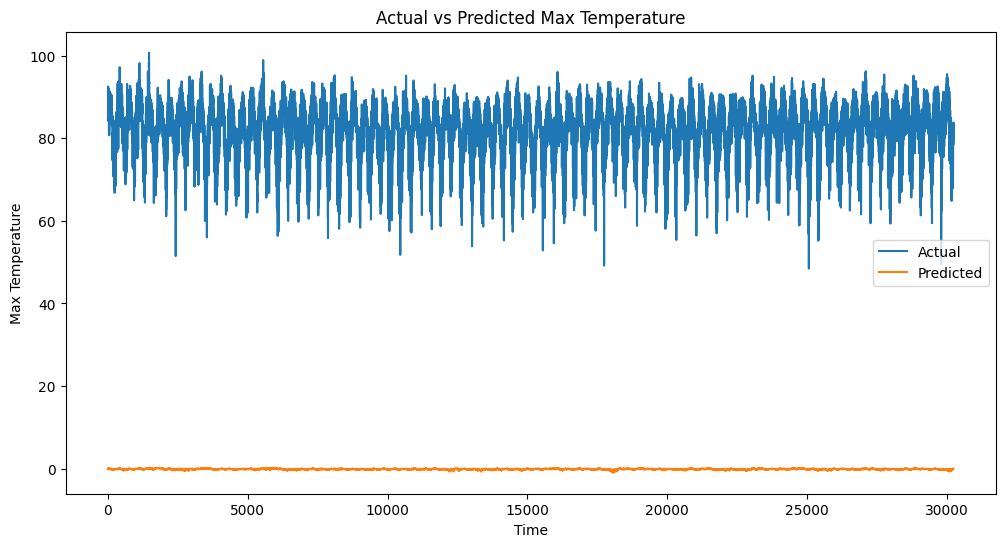

                                                    date  temperature_2m_max  \
512                            1941-05-27 00:00:00+00:00           84.775100   
513                            1941-05-28 00:00:00+00:00           84.235100   
514                            1941-05-29 00:00:00+00:00           84.505104   
515                            1941-05-30 00:00:00+00:00           88.915100   
516                            1941-05-31 00:00:00+00:00           89.545105   
...                                                  ...                 ...   
2052-10-06 00:00:00.000000512                        NaN                 NaN   
2052-10-07 00:00:00.000000512                        NaN                 NaN   
2052-10-08 00:00:00.000000512                        NaN                 NaN   
2052-10-09 00:00:00.000000512                        NaN                 NaN   
2052-10-10 00:00:00.000000512                        NaN                 NaN   

                               max_temp

In [6]:
import matplotlib.pyplot as plt
from tqdm import tqdm

# Prepare the input data
window_size = config.context_length
predicted_values = []
actual_values = []

for i in tqdm(range(window_size, len(max_temp)), desc="Prediction Progress"):
    past_values = torch.tensor(max_temp[i-window_size:i], dtype=torch.float32).unsqueeze(0)
    actual_value = max_temp[i]
    
    # Generate predictions
    with torch.no_grad():
        outputs = model(past_values=past_values)
        predicted_value = outputs.regression_outputs.squeeze().item()
    
    predicted_values.append(predicted_value)
    actual_values.append(actual_value)

# Create a DataFrame with the predicted values
future_dates = pd.date_range(start=weather_data.index[window_size], periods=len(predicted_values), freq='D')
predicted_data = pd.DataFrame({'max_temp': predicted_values}, index=future_dates)

# Concatenate the historical data with the predicted data
combined_data = pd.concat([weather_data[window_size:], predicted_data])

# Plot the actual values vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(actual_values, label='Actual')
plt.plot(predicted_values, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Max Temperature')
plt.legend()
plt.title('Actual vs Predicted Max Temperature')
plt.show()

# Print the combined data
print(combined_data)